In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm
import scipy.optimize as optimize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from astropy.io import ascii
import emcee as emcee
from astropy import constants, units
import os
import corner
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import norm, uniform
from scipy import optimize

from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.stats import truncnorm

## Load Data and Normalize Units

In [2]:
## load data

# define data directories

def get_data_version(file_type, archive,file_number,non_vla_freq_index_cutoff):
    dir_name = '/Users/calebpainter/Downloads/Research/THESIS/data'
    image_files = os.listdir(dir_name + '/image')

    # non-VLA archival
    non_vla = ascii.read(dir_name+'/MWC480.spec.txt')  
    lambda_non_vla, snu_non_vla, snu_err_non_vla = non_vla['col1'], non_vla['col2'], non_vla['col3']
    nu_non_vla = np.array([(constants.c/(units.micron * x)).to(units.GHz).value for x in lambda_non_vla])

    # set what data you want (vis vs imge, include archival or no, which image data you want, when you want vla_freq cutoff to be)

    # record as the data files
    data_version = {
        'File Type:': file_type,
        'Non-VLA Archive and Cutoff': (archive, non_vla_freq_index_cutoff),
        'File Number (if multiple)': file_number
    }


    if file_type == 'img':
        image_np= np.load(dir_name+f'/image/{image_files[file_number]}')
        nu_img, Snu_img, err_Snu_img = image_np['nu'], image_np['Snu'], image_np['eSnu']

    
        if archive == True:

            nu_hz_combined_img = np.array(list(nu_img*(10**9)) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_img = np.array(list(Snu_img*(10**6)) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_img = np.array(list(err_Snu_img*(10**6)) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])

            mcmc_nu = nu_hz_combined_img
            mcmc_Snu = snu_uJy_combined_img
            mcmc_Snu_err= snu_err_uJy_combined_img

        elif archive == False:
            mcmc_nu = nu_img
            mcmc_Snu = Snu_img
            mcmc_Snu_err= err_Snu_img

    elif file_type == 'vis':
        # visibility-based spectrum
        _ = np.load(dir_name+'/MWC480.vis_fluxes.npz')
        nu_vis, Snu_vis, err_Snu_vis = _['nu'], _['Fnu'], _['eFnu']

        if archive == True:

            nu_hz_combined_vis = np.array(list(nu_vis) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_vis = np.array(list(Snu_vis) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_vis = np.array(list(err_Snu_vis) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])


            mcmc_nu = nu_hz_combined_vis
            mcmc_Snu = snu_uJy_combined_vis
            mcmc_Snu_err= snu_err_uJy_combined_vis

        elif archive == False:
            mcmc_nu = nu_vis
            mcmc_Snu = Snu_vis
            mcmc_Snu_err= err_Snu_vis


    ## convert all frequencies to GHz
    mcmc_nu = mcmc_nu/(10**9)

    # add calibration errors as list
    flux_scale_errors = np.zeros(len(mcmc_nu))

    indices_17Ghz = np.where(mcmc_nu < 17)[0] 
    indices_50Ghz = np.where((mcmc_nu < 50) &(mcmc_nu > 17) )[0] 
    indices_100Ghz = np.where(mcmc_nu > 50)[0] 

    flux_scale_errors[indices_17Ghz] = .03
    flux_scale_errors[indices_50Ghz] = .05
    flux_scale_errors[indices_100Ghz] = .1

    ## add in NOEMA data
    image_np= np.load(dir_name+'/MWC480_NOEMA.imf_fluxes.npz')
    nu_noema, Snu_noema, err_Snu_noema = image_np['nu'], image_np['Snu'], image_np['eSnu']

    NOEMA_flux_scale_errors = np.zeros(len(nu_noema))

    indices_lower = np.where(nu_noema < 110)[0] 
    indices_upper = np.where(nu_noema > 110)[0] 

    NOEMA_flux_scale_errors[indices_lower] = .08
    NOEMA_flux_scale_errors[indices_upper] = .1

    mcmc_nu = np.array(list(mcmc_nu) + list(nu_noema))
    mcmc_Snu = np.array(list(mcmc_Snu) + list(Snu_noema*(10**6)))
    mcmc_Snu_err = np.array(list(mcmc_Snu_err) + list(err_Snu_noema*(10**6)))
    flux_scale_errors = np.array(list(flux_scale_errors) + list(NOEMA_flux_scale_errors))
    
    flux_scale_errors_scaled = flux_scale_errors * mcmc_Snu

    # sort by frequencies
    sorted_indices = np.argsort(mcmc_nu)

    mcmc_nu = mcmc_nu[sorted_indices]
    mcmc_Snu = mcmc_Snu[sorted_indices]
    mcmc_Snu_err = mcmc_Snu_err[sorted_indices]
    flux_scale_errors = flux_scale_errors[sorted_indices]
    flux_scale_errors_scaled = flux_scale_errors_scaled[sorted_indices]
    print(mcmc_nu)

    return data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err, flux_scale_errors, flux_scale_errors_scaled



[  4.31881359   4.74848999   5.25687631   5.70940212   6.23398174
   6.75200793   7.24541085   7.74701072   8.51277196   9.50699917
  10.49267902  11.43469008  13.0255142   14.36086205  15.83715999
  17.31824085  18.98760842  20.66788844  23.11714062  25.04236363
  30.01229633  31.88177089  33.96032224  35.94379759  41.80042073
  45.64033322  80.22440261  84.28688547  88.22437661  92.2868958
  95.71424372  99.77672658 103.71435622 107.77687541 130.22694433
 134.28877738 138.22643538 142.2889276  145.71430777 149.77614082
 153.71631218 157.7788044 ]


Text(0, 0.5, 'Intensity [micro Jansky]')

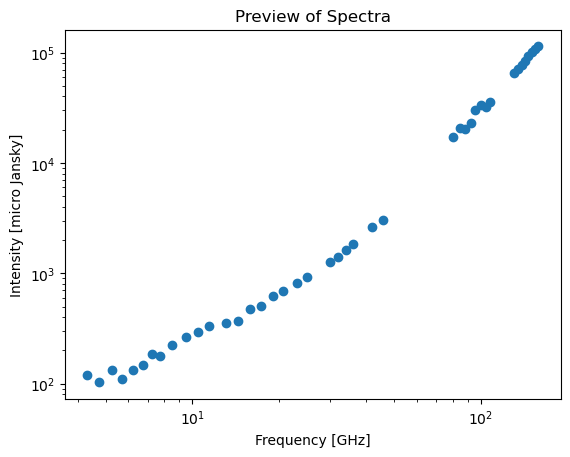

In [82]:
data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('vis',False,0,4)
plt.scatter(mcmc_nu,mcmc_Snu)
plt.xscale('log')
plt.yscale('log')
plt.title("Preview of Spectra")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Intensity [micro Jansky]")

## TMCMC Set Up, Likelihood Functions, Priors

In [37]:
def sample_TMCMC(log_likelihood,
                 log_prior_density,
                 prior_sampler,
                 parameterization,
                 data,
                 beta: float,
                 gamma: float,
                 num_samples: int):
    zeta = 0
    S = 1.0
    j = 1

    samples = np.array([prior_sampler(parameterization) for i in range(num_samples)])

    while zeta < 1:
        log_fvals = np.array([log_likelihood(theta,data,parameterization) for theta in samples])

        # adapt zeta
        zeta0 = zeta

        def cv(z):
            a = np.exp((z-zeta0) * log_fvals)
            return np.std(a) / np.mean(a)

        res = optimize.fsolve(lambda z: cv(z[0]) - gamma, x0=[zeta])
        zeta = min([1.0, res[0]])

        # compute plausibility weights and update S
        wj = np.exp(log_fvals * (zeta-zeta0))
        S *= np.mean(wj)

        cov = beta**2 * np.cov(samples.T)

        # resample
        candidate_samples = samples.copy()
        candidate_log_fvals = log_fvals.copy()
        num_times_chosen = np.zeros(num_samples, dtype=int)

        for k in range(num_samples):
            i = np.random.choice(np.arange(num_samples), p=wj/np.sum(wj))
            if num_times_chosen[i] > 0:
                # MH step
                x = candidate_samples[i]
                log_f = zeta * candidate_log_fvals[i] + log_prior_density(x,parameterization)

                xp = np.random.multivariate_normal(mean=x, cov=cov)
                log_fvalp = log_likelihood(xp,data,parameterization)
                log_fp = log_prior_density(xp,parameterization) + zeta *  log_fvalp

                if log_fp >= log_f + np.log(np.random.uniform(0, 1)):
                    candidate_samples[i] = xp
                    candidate_log_fvals[i] = log_fvalp

            num_times_chosen[i] += 1

            samples[k] = candidate_samples[i].copy()
            log_fvals[k] = candidate_log_fvals[i]

        print(f"stage {j}: zeta = {zeta}, S = {S}")

        j += 1

    return samples, S



def main(model_num, parameterization):
    np.random.seed(123456)

    x_data = mcmc_nu
    y_data = mcmc_Snu
    y_data_err = mcmc_Snu_err

    # normalize Nu Vis to Ghz
    scaled_x_data = x_data / (33)

    n = len(x_data)    

    models = ['single power law', 'two power law', 'spinning dust + power law', 'three power law']
    labels = [['Ftot','alpha dust'],['chi','Ftot','alpha dust','alpha cont','log_f'],[r'$S_v^{cont}$',r'$S_v^{dust1}$',r'$\alpha_{cont}$',r'$\alpha_{dust1}$',r'$\alpha_{dust2}$',r'$v_{\rm switch}$','log_f'],[r'$S_v^{cont}$',r'$S_v^{dust1}$',r'$\alpha_{cont}$',r'$\alpha_{dust1}$',r'$\alpha_{dust2}$',r'$v_{\rm switch}$','log_f']]

    print('Model', models[model_num])
    
    S = 10.0  # Scale for priors.

    def log_prior_density(params,parameterization = 1):
        """Computes the log-prior density."""

        if parameterization == 1:
            if model_num == 0:
                flux1, alpha_dust, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(flux1, loc=800, scale=100) + norm.logpdf(alpha_dust, loc=3, scale=.5) + log_prior_sigma 

            if model_num == 1:
                flux1, flux2, alpha_dust, alpha_cont, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(flux1, loc=800, scale=100) + norm.logpdf(flux2, loc=800, scale=100) + norm.logpdf(alpha_dust, loc=3, scale=.5)+ norm.logpdf(alpha_cont, loc=1, scale=.5) + log_prior_sigma 

            if model_num == 2:
                flux1, flux2, flux3, alpha_dust, alpha_cont, spin_center, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(flux1, loc=800, scale=100) + norm.logpdf(flux2, loc=800, scale=100) + norm.logpdf(flux3, loc=150, scale=50) + norm.logpdf(alpha_dust, loc=3, scale=.5)+ norm.logpdf(alpha_cont, loc=1, scale=.5)+ norm.logpdf(spin_center, loc=.5, scale=.1) + log_prior_sigma 
            
            if model_num == 3:
                flux1, flux2, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch, log_f = params
                
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(flux1, loc=850, scale=100) + norm.logpdf(flux2, loc=700, scale=100) + norm.logpdf(alpha_dust1, loc=3.5, scale=.5)+ norm.logpdf(alpha_cont, loc=1, scale=.5)+ norm.logpdf(alpha_dust2, loc=2.5, scale=.5) +truncnorm.logpdf(alpha_switch, loc=3.5, scale=1, a=0, b=np.inf)+ log_prior_sigma 

        if parameterization == 2:

            total_flux_mu_hyper = 2000
            total_flux_scale_hyper = 200

            # on scale from 0 to 5
            uniformative_alpha_mu_hyper = 2.5
            uniformative_alpha_scale_hyper = 1

            if model_num == 0:
                flux1, alpha_dust, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(flux1, loc=total_flux_mu_hyper, scale=total_flux_scale_hyper) + norm.logpdf(alpha_dust, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + log_prior_sigma 

            if model_num == 1:
                total_flux, chi1, alpha_dust, alpha_cont, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(total_flux, loc=total_flux_mu_hyper, scale=total_flux_scale_hyper) + uniform.logpdf(chi1, loc=0, scale=1) + norm.logpdf(alpha_dust, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + norm.logpdf(alpha_cont, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + log_prior_sigma 

            if model_num == 2:
                total_flux, chi1, chi2, alpha_dust, alpha_cont, spin_center, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(total_flux, loc=total_flux_mu_hyper, scale=total_flux_scale_hyper) + uniform.logpdf(chi1, loc=0, scale=1) + uniform.logpdf(chi2, loc=0, scale=1) + norm.logpdf(alpha_dust, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + norm.logpdf(alpha_cont, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + uniform.logpdf(spin_center, loc=0, scale=12) + log_prior_sigma 
            
            if model_num == 3:
                total_flux, chi1, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch, log_f = params
                log_prior_sigma = norm.logpdf(log_f, loc=0, scale=S)
                full_prior = norm.logpdf(total_flux, loc=total_flux_mu_hyper, scale=total_flux_scale_hyper) + uniform.logpdf(chi1, loc=0, scale=1) + norm.logpdf(alpha_dust1, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)+ norm.logpdf(alpha_dust1, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + norm.logpdf(alpha_cont, loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper) + uniform.logpdf(alpha_switch, loc=0, scale=12) + log_prior_sigma 


        return full_prior

    def prior_sampler(parameterization = 1):
        """Samples from the prior distribution."""

        if parameterization == 1:
            if model_num == 0:
                flux1 = np.random.normal(loc=1600, scale=200)
                alpha1 = np.random.normal(loc=2.5, scale=1)  # Powers (p2).
                sigma = np.random.normal(loc=0, scale=S)  # Noise term.
                full_sample = np.array([flux1,alpha1,sigma])

            if model_num == 1:
                flux1 = np.random.normal(loc=800, scale=100)
                flux2 = np.random.normal(loc=800, scale=100)  # Scaling coefficients (p1).
                alpha1 = np.random.normal(loc=3, scale=.5)  # Powers (p2).
                alpha2 = np.random.normal(loc=1, scale=.1)
                sigma = np.random.normal(loc=0, scale=S)  # Noise term.
                full_sample = np.array([flux1, flux2,alpha1, alpha2,sigma])

            if model_num == 2:
                flux1 = np.random.normal(loc=800, scale=100)
                flux2 = np.random.normal(loc=800, scale=100)  
                flux3 = np.random.normal(loc=150, scale=50)  
                alpha1 = np.random.normal(loc=3, scale=.5)  
                alpha2 = np.random.normal(loc=1, scale=.1)
                spin =  np.random.normal(loc=.5, scale=.1)
                sigma = np.random.normal(loc=0, scale=S) 
                full_sample = np.array([flux1, flux2, flux3, alpha1, alpha2, spin,sigma])

            if model_num == 3:
                flux1 = np.random.normal(loc=800, scale=100)
                flux2 = np.random.normal(loc=800, scale=100)  
                alpha_cont = np.random.normal(loc=1, scale=.5)  
                alpha_dust1 = np.random.normal(loc=3.5, scale=.5)  
                alpha_dust2 = np.random.normal(loc=2.5, scale=.5)

                ## cannot be negative!
                alpha_switch = truncnorm.rvs(0, 100, loc=3.5, scale=1)
                sigma = np.random.normal(loc=0, scale=S) 
                full_sample = np.array([flux1, flux2, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch,sigma])


        elif parameterization == 2:
            total_flux_mu_hyper = 2000
            total_flux_scale_hyper = 200

            # on scale from 0 to 5
            uniformative_alpha_mu_hyper = 2.5
            uniformative_alpha_scale_hyper = 1

            scaled_full_data_range = 400/33

            total_flux = np.random.normal(loc=total_flux_mu_hyper, scale=total_flux_scale_hyper)
            sigma = np.random.normal(loc=0, scale=S)  # Noise term.

            if model_num == 0:
                alpha1 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                full_sample = np.array([total_flux,alpha1,sigma])

            if model_num == 1:
                chi1 = np.random.uniform()
                alpha1 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                alpha2 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                full_sample = np.array([total_flux, chi1 ,alpha1, alpha2,sigma])

            if model_num == 2:
                chi1 = np.random.uniform()
                chi2 = np.random.uniform()
                alpha1 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                alpha2 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                spin =  np.random.uniform(0,scaled_full_data_range)
                full_sample = np.array([total_flux, chi1, chi2, alpha1, alpha2, spin,sigma])
            
            if model_num == 3:
                chi1 =  np.random.uniform()
                
                alpha_cont = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                alpha_dust1 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  
                alpha_dust2 = np.random.normal(loc=uniformative_alpha_mu_hyper, scale=uniformative_alpha_scale_hyper)  

                ## cannot be negative!
                alpha_switch = np.random.uniform(0,scaled_full_data_range)
                sigma = np.random.normal(loc=0, scale=S) 
                full_sample = np.array([total_flux, chi1, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch,sigma])


        return full_sample


    def log_likelihood(params, data,parameterization):


        """Computes the log-likelihood."""
        x_data, y_data, y_data_err = data

        if parameterization == 1:
            if model_num == 0:

                flux1, alpha_dust, log_f = params
                model = flux1*(x_data)**alpha_dust 

            if model_num == 1:

                flux1, flux2, alpha_dust, alpha_cont,log_f = params 
                model = flux1*(x_data)**alpha_dust + flux2*(x_data)**alpha_cont

            if model_num == 2:
                Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center, log_f = params 
                model = Fdust*(x_data)**alpha_dust + Fbrehm*(x_data)**alpha_brehm + Fspin*(x_data/spin_center)**2*np.exp((1-(x_data/spin_center)**2 ))


            if model_num == 3:
                flux1, flux2, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch, log_f = params

                flux3 = flux2 * alpha_switch**np.abs((alpha_dust1-alpha_dust2))

                baseline = flux1 * x_data ** alpha_cont
                dust = np.where(x_data < alpha_switch, flux2 * x_data ** alpha_dust1, flux3 * x_data ** alpha_dust2)
                model = baseline + dust
            

        if parameterization == 2:
            if model_num == 0:

                tot_flux, alpha_dust, log_f = params
                model = tot_flux*(x_data)**alpha_dust 

            if model_num == 1:

                tot_flux, chi1, alpha_dust, alpha_cont,log_f = params 
                model = tot_flux*(1-chi1)*(x_data)**alpha_dust + tot_flux*(chi1)*(x_data)**alpha_cont

            if model_num == 2:
                tot_flux, chi1, chi2, alpha_dust, alpha_brehm, spin_center, log_f = params 
                model = tot_flux*(1-chi1-chi2)*(x_data)**alpha_dust + tot_flux*(chi1)*(x_data)**alpha_brehm + tot_flux*(chi2)*(x_data/spin_center)**2*np.exp((1-(x_data/spin_center)**2 ))
            
            if model_num == 3:

                tot_flux, chi1, alpha_cont, alpha_dust1, alpha_dust2, alpha_switch, log_f = params

                flux1 = tot_flux*chi1
                flux2 = tot_flux*(1-chi1)

                flux3 = flux2 * alpha_switch**np.abs((alpha_dust1-alpha_dust2))

                baseline = flux1 * x_data ** alpha_cont
                dust = np.where(x_data < alpha_switch, flux2 * x_data ** alpha_dust1, flux3 * x_data ** alpha_dust2)
                model = baseline + dust
            
        sigma2 = y_data_err**2 + model**2 * np.exp(2*log_f)


        log_likelihood = -0.5 * np.sum((y_data - model) ** 2 / sigma2 + np.log(sigma2))
        return log_likelihood


    # Perform TMCMC sampling.
    sample, S = sample_TMCMC(log_likelihood=log_likelihood,
                           log_prior_density=log_prior_density,
                           prior_sampler=prior_sampler,
                           data = (scaled_x_data, y_data, y_data_err),
                           parameterization = parameterization,
                           beta=0.2,
                           gamma=0.6,
                           num_samples=5000)
    
    return sample, S


In [67]:
sample0, S_0 = main(0,2)
sample1, S_1 = main(1,2)
sample2, S_2 = main(2,2)
# sample3, S_3 = main(3,2)


evidence_sum =  S_1 + S_3
# model0_evidence = S_0 / evidence_sum
model1_evidence = S_1 / evidence_sum
# model2_evidence = S_2 / evidence_sum
model3_evidence = S_3 / evidence_sum

print("With Un-Informative Priors")
# print("Model 0 Evidence: ", model0_evidence)
print("Model 1 Evidence: ", model1_evidence)
# print("Model 2 Evidence: ", model2_evidence)
print("Model 3 Evidence: ", model3_evidence)

Model two power law
stage 1: zeta = 2.288724989479002e-05, S = 0.6862061619868157
stage 2: zeta = 0.0012489559496359488, S = 0.2058888782273177
stage 3: zeta = 0.004493918335413148, S = 0.022326290055669717
stage 4: zeta = 0.009962565380504886, S = 0.0009569003431330916
stage 5: zeta = 0.0183329518078721, S = 1.317408463005647e-05
stage 6: zeta = 0.03026398739107678, S = 4.770734669905331e-08
stage 7: zeta = 0.04569491913810108, S = 5.0940271433952206e-11
stage 8: zeta = 0.06444982652016827, S = 1.819224510772711e-14
stage 9: zeta = 0.0879577227050257, S = 1.3106962996817615e-18
stage 10: zeta = 0.12120139737657162, S = 2.9518403269717133e-24
stage 11: zeta = 0.1700359179217479, S = 2.495684552656387e-32
stage 12: zeta = 0.23878108445992696, S = 1.7681661762571776e-43
stage 13: zeta = 0.33155217523648495, S = 2.5574463920351746e-58
stage 14: zeta = 0.44705354661979463, S = 1.2946973639933755e-76
stage 15: zeta = 0.597804597926003, S = 2.673718034215685e-100
stage 16: zeta = 0.818439333

/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_42050/3378662370.py:287: RuntimeWarning: invalid value encountered in scalar power
  flux3 = flux2 * alpha_switch**np.abs((alpha_dust1-alpha_dust2))


stage 1: zeta = 1.9237505202247995e-05, S = 0.6914275053802541
stage 2: zeta = 0.0013890986373229638, S = 0.19143344520843433
stage 3: zeta = 0.004780316665142015, S = 0.01939114667841267
stage 4: zeta = 0.010545957740122784, S = 0.0007261976705908346
stage 5: zeta = 0.019361085236767706, S = 8.146649499071321e-06
stage 6: zeta = 0.031584894915225675, S = 2.5841025113768788e-08
stage 7: zeta = 0.047596428363148854, S = 2.1152622928565062e-11
stage 8: zeta = 0.06731388077069579, S = 5.027117109710444e-15
stage 9: zeta = 0.09208581730486134, S = 2.1627841958811876e-19
stage 10: zeta = 0.1226961487485447, S = 1.3086782024294679e-24
stage 11: zeta = 0.15689018066122257, S = 2.7621261100841166e-30
stage 12: zeta = 0.19341141474755916, S = 3.368836510785319e-36
stage 13: zeta = 0.2351574351704902, S = 8.41902513012059e-43
stage 14: zeta = 0.2909123110392761, S = 2.007535579236486e-51
stage 15: zeta = 0.38220588782841747, S = 2.803147156802156e-65
stage 16: zeta = 0.533134187298638, S = 6.491

## Calculate Evidence

In [83]:
sample0, S_0 = main(0,1)
sample1, S_1 = main(1,1)
sample2, S_2 = main(2,1)
# sample3, S_3 = main(3,1)

evidence_sum = S_0 + S_1 + S_2 
model0_evidence = S_0 / evidence_sum
model1_evidence = S_1 / evidence_sum
model2_evidence = S_2 / evidence_sum
# model3_evidence = S_3 / evidence_sum


print("With Informative Priors")
print("Model 0 Evidence: ", model0_evidence)
print("Model 1 Evidence: ", model1_evidence)
print("Model 2 Evidence: ", model2_evidence)
# print("Model 3 Evidence: ", model3_evidence)

Model single power law
stage 1: zeta = 2.7170891557291914e-05, S = 0.6811935865878163
stage 2: zeta = 0.001254792266828034, S = 0.23923345940208646
stage 3: zeta = 0.005017656003740184, S = 0.02882509527493423
stage 4: zeta = 0.01149979022332811, S = 0.0013962520723799947
stage 5: zeta = 0.022476323192032546, S = 1.519297570110446e-05
stage 6: zeta = 0.04065775726178919, S = 1.512276976021702e-08
stage 7: zeta = 0.07114868841953793, S = 2.4896589775282044e-13
stage 8: zeta = 0.12274062696144458, S = 3.600505355719578e-21
stage 9: zeta = 0.20779135972157362, S = 7.457504799717972e-34
stage 10: zeta = 0.3392118173325266, S = 3.153862658300541e-53
stage 11: zeta = 0.5298643210897895, S = 3.947783569909648e-81
stage 12: zeta = 0.7908254760151243, S = 3.899154000592833e-119
stage 13: zeta = 1.0, S = 1.6552494131574195e-149
Model two power law
stage 1: zeta = 0.00010725026972004365, S = 0.6616205664359982
stage 2: zeta = 0.002231060967637649, S = 0.18070858964955921
stage 3: zeta = 0.0067285

In [68]:
# sample0, S_0 = main(0,2)
sample1, S_1 = main(1,1)
# sample2, S_2 = main(2,2)
sample3, S_3 = main(3,1)


evidence_sum =  S_1 + S_3
# model0_evidence = S_0 / evidence_sum
model1_evidence = S_1 / evidence_sum
# model2_evidence = S_2 / evidence_sum
model3_evidence = S_3 / evidence_sum

print("With Un-Informative Priors")
# print("Model 0 Evidence: ", model0_evidence)
print("Model 1 Evidence: ", model1_evidence)
# print("Model 2 Evidence: ", model2_evidence)
print("Model 3 Evidence: ", model3_evidence)

Model two power law
stage 1: zeta = 4.228816461886276e-05, S = 0.6789889698871264
stage 2: zeta = 0.0018275326752473738, S = 0.16853970490702144
stage 3: zeta = 0.00570739341410015, S = 0.017956840454724152
stage 4: zeta = 0.012694064788963809, S = 0.0005918904679549842
stage 5: zeta = 0.024978047431498698, S = 2.768277512852745e-06
stage 6: zeta = 0.0447673342928273, S = 8.563136087326271e-10
stage 7: zeta = 0.07478523088697418, S = 6.9391026397031325e-15
stage 8: zeta = 0.12009006414460778, S = 2.4323019850955033e-22
stage 9: zeta = 0.18956569285675656, S = 1.5300612874375393e-33
stage 10: zeta = 0.29518835226563683, S = 2.4388017184045453e-50
stage 11: zeta = 0.44746396089479795, S = 2.4437663631359106e-74
stage 12: zeta = 0.6582013613541889, S = 2.414482489587834e-107
stage 13: zeta = 0.943977535386581, S = 6.767757360501084e-152
stage 14: zeta = 1.0, S = 1.3019596905289966e-160
Model three power law
stage 1: zeta = 4.7600970589024054e-05, S = 0.677137575192367
stage 2: zeta = 0.00

## Plot Models

In [11]:

def get_quantiles(samples: np.ndarray, model_num, x_data: np.ndarray, q: float):
    
    if model_num == 0:
        flux1 = samples[:, 0]
        alpha_dust = samples[:, 1]
        sigma = samples[:, 2]
    elif model_num == 1:
        flux1 = samples[:, 0]
        flux2 = samples[:, 1]
        alpha_dust = samples[:, 2]
        alpha_cont = samples[:, 3]
        sigma = samples[:, 4]
    elif model_num == 2:
        flux1 = samples[:, 0]
        flux2 = samples[:, 1]
        flux3 = samples[:, 2]
        alpha_dust = samples[:, 3]
        alpha_cont = samples[:, 4]
        spin = samples[:, 5]
        sigma = samples[:, 6]
    elif model_num == 3:
        flux1 = samples[:, 0]
        flux2 = samples[:, 1]
        alpha_cont = samples[:, 2]
        alpha_dust1 = samples[:, 3]
        alpha_dust2 = samples[:, 4]
        alpha_switch = samples[:, 5]
        sigma = samples[:, 6]

    else:
        raise ValueError("Invalid model_num. Must be 0, 1, or 2.")

    # Store the quantiles for each x in x_data
    y_quantiles = []

    for x in x_data:
        # Generate predictive distributions for each sample
        if model_num == 0:
            predictions = flux1 * (x ** alpha_dust)
        elif model_num == 1:
            predictions = (flux1 * (x ** alpha_dust)) + (flux2 * (x ** alpha_cont))
        elif model_num == 2:
            predictions = (
                flux1 * (x ** alpha_dust) +
                flux2 * (x ** alpha_cont) +
                flux3 * ((x / spin) ** 2) * np.exp(1 - (x / spin) ** 2)
            )
        elif model_num == 3:
            flux3 = flux2 * alpha_switch**np.abs((alpha_dust1-alpha_dust2))
            baseline = flux1 * x ** alpha_cont
            dust = np.where(x < alpha_switch, flux2 * x ** alpha_dust1, flux3 * x ** alpha_dust2)
            predictions = (baseline + dust)

        # Add noise based on sigma
        noisy_predictions = predictions + np.exp(sigma)

        # Compute the desired quantile for the predictive distribution
        y_quantile = np.quantile(noisy_predictions, q)
        y_quantiles.append(y_quantile)

    return np.array(y_quantiles)


In [80]:
def plot_tmcmc_results(model_num, scaling, samples, params, norm_nu_vis):

    labels = [['Ftot','alpha dust'],['chi','Ftot','alpha dust','alpha cont','log_f'],[r'$S_v^{cont}$',r'$S_v^{dust1}$',r'$\alpha_{cont}$',r'$\alpha_{dust1}$',r'$\alpha_{dust2}$',r'$v_{\rm switch}$','log_f'],[r'$S_v^{cont}$',r'$S_v^{dust1}$',r'$\alpha_{cont}$',r'$\alpha_{dust1}$',r'$\alpha_{dust2}$',r'$v_{\rm switch}$','log_f']]

    nu_model = np.linspace(1/33, 300,10000)
    # nu_model = norm_nu_vis

    fontsize= 20

    plotting_fig, axs = plt.subplots(1,1,figsize=(8,6))

    if model_num == 0:

        ndim = 3

        flux1, alpha_dust, log_f = params 

        dust_Sv = flux1*(nu_model)**alpha_dust 

        print('2 free parameter fit')
        print('mcmc params',params)
        model_Sv = dust_Sv
        likelihood_model_Sv = flux1*(norm_nu_vis)**alpha_dust 

        nu_model = nu_model * scaling
        axs.plot(nu_model, dust_Sv,color='purple',ls='--',label='Dust Emission',linewidth=2)

        text = (
            r"F$_{\rm dust}$= " + f'{np.round(flux1,2)}\n' + 
            r'$\alpha^{d}=$' + f'{np.round(alpha_dust,2)}' 
        )


    if model_num == 1:

        ndim = 5

        flux1, flux2, alpha_dust, alpha_cont, log_f = tuple(params)
        # chi, tot_flux, alpha_dust, alpha_cont =0.18130303539575973, 1772.2775570866784, 2.6438262226287677, 0.5

        print('4 free parameter fit')
        print('mcmc params',params)
        dust_Sv = flux1*(nu_model)**alpha_dust
        cont_Sv = flux2*(nu_model)**alpha_cont
        model_Sv = dust_Sv + cont_Sv
        likelihood_model_Sv = flux1*(norm_nu_vis)**alpha_dust + flux2*(norm_nu_vis)**alpha_cont

        nu_model = nu_model * scaling
        axs.plot(nu_model, model_Sv,color='purple',label='Contamination + Dust')
        axs.plot(nu_model, dust_Sv,color='blue',ls='--',label='Dust Emission')
        axs.plot(nu_model, cont_Sv,color='red',ls='--', label='Bremsstrahlung')

        text = (
            r"F$_{\rm dust}$= " + f'{np.round(flux1,2)}\n' + 
             r"F$_{\rm cont}$=" + f'{int(np.round(flux2,2))}\n' + 
            r'$\alpha^{d}=$' + f'{np.round(alpha_dust,2)}\n' + 
            r'$\alpha^{c}=$' + f'{np.round(alpha_cont,2)}'
        )

    if model_num == 2:
        
        ndim = 5

        Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center, log_f = params 


        print('4 free parameter fit')
        print('mcmc params',params)
        dust_Sv = Fdust*(nu_model)**alpha_dust
        cont_Sv = Fbrehm*(nu_model)**alpha_brehm
        spin_Sv = Fspin*(nu_model/spin_center)**2*np.exp((1-(nu_model/spin_center)**2 ))
        model_Sv = dust_Sv + cont_Sv + spin_Sv
        
        likelihood_model_Sv = Fdust*(norm_nu_vis)**alpha_dust + Fbrehm*(norm_nu_vis)**alpha_brehm + Fspin*(norm_nu_vis/spin_center)**2*np.exp((1-(norm_nu_vis/spin_center)**2 ))

        nu_model = nu_model * scaling
        axs.plot(nu_model, model_Sv,color='purple',label='Contamination + Dust')
        axs.plot(nu_model, dust_Sv,color='blue',ls='--',label='Dust Emission')
        axs.plot(nu_model, cont_Sv,color='red',ls='--', label='Brehmstrallung')
        axs.plot(nu_model, spin_Sv,color='orange',ls='--', label='Spin')

        text = (
            r"F$_{\rm dust}$= " + f'{np.round(Fdust,2)}\n' + 
             r"F$_{\rm cont}$=" + f'{int(np.round(Fbrehm,2))}\n' +
             r"F$_{\rm spin}$=" + f'{int(np.round(Fspin,2))}\n' + 
            r'$\alpha^{d}=$' + f'{np.round(alpha_dust,2)}\n' + 
            r'$\alpha^{c}=$' + f'{np.round(alpha_brehm,2)}\n' + 
            r'$\nu_{\rm spin}=$' + f'{np.round(spin_center,2)}\n'

        )




    if model_num == 3:

        ndim = 7

        f1, f2, a1, a2, a3, switch, log_f = tuple(params)

        
        f3 = f2 * switch**(a2-a3)

        cont_Sv = f1 * nu_model ** a1
        dust_Sv = np.where(nu_model < switch, f2 * nu_model ** a2, f3 * nu_model ** a3)
        model_Sv = cont_Sv + dust_Sv


        nu_model = nu_model * scaling

        axs.plot(nu_model, model_Sv,color='purple',label='Contamination + Dust')
        axs.plot(nu_model, dust_Sv,color='blue',ls='--',label='Dust Emission')
        axs.plot(nu_model, cont_Sv,color='red',ls='--',label='Contamination')


        likelihood_cont_Sv = f1 * norm_nu_vis ** a1
        likelihood_dust_Sv = np.where(norm_nu_vis < switch, f2 * norm_nu_vis ** a2, f3 * norm_nu_vis ** a3)
        likelihood_model_Sv = likelihood_cont_Sv + likelihood_dust_Sv


        spec_labels = labels[model_num]
        text = ""
        for i in range(ndim):
            if i < 2:
                text+= spec_labels[i] + f'= {int(np.round(params[i]))}\n'
            if 1 < i < ndim-1:
                text+= spec_labels[i] + f'= {np.round(params[i],2)}\n'
            if i == ndim-1:
                text+= spec_labels[i] + f'= {np.round(params[i],2)}'


        print('mcmc params',params)



    flat_samples = samples.reshape((-1, ndim))  # Flatten the samples

    # Labels for the corner plot
    corner_labels = ["$\\chi$", "$S_{cm}$", "$\\alpha^d$", "$\\alpha^c$"] if ndim == 4 else labels

    x_ = np.linspace(1/33, 300,1000)

    y_median = get_quantiles(samples, model_num, x_, q=0.5)
    y_05 = get_quantiles(samples,model_num, x_, q=0.05)
    y_95 = get_quantiles(samples,model_num, x_, q=0.95)
    axs.fill_between(x_*33, y_05, y_95, color='purple', alpha=0.2, lw=0)

    


    axs.legend(loc='upper left', fontsize= fontsize -5)
    axs.set_xlabel(f"Freq [GHz]", fontsize= fontsize)
    axs.set_ylabel(r"uJy",fontsize= fontsize)

    axs.scatter(mcmc_nu, mcmc_Snu,color='black',s=20, marker='s')
    axs.errorbar(mcmc_nu,mcmc_Snu, mcmc_Snu_err, color='black',fmt='none')

    axs.set_xscale('log'); axs.set_yscale('log')

    large = True
    if large == True:
        axs.set_ylim(20,3*10**7)
        axs.set_xlim(4,500)
    else:
        axs.set_ylim(20,3*10**5)
        axs.set_xlim(4,200)



    props = dict(boxstyle='round', facecolor='white', alpha=0.5)  # Customize the appearance
    if model_num == 1:
        axs.text(.03, .75, text, transform=plt.gca().transAxes, fontsize=fontsize-5,
                verticalalignment='top', bbox=props)
    elif model_num == 0:
        axs.text(.03, .85, text, transform=plt.gca().transAxes, fontsize=fontsize-5,
                verticalalignment='top', bbox=props)
    elif model_num == 2:
        axs.text(.03, .7, text, transform=plt.gca().transAxes, fontsize=fontsize-5,
                verticalalignment='top', bbox=props)

    elif model_num == 3:
        axs.text(.03, .7, text, transform=plt.gca().transAxes, fontsize=fontsize-5,
                verticalalignment='top', bbox=props)


    axs.grid(alpha=.3,which='both',ls='--')

    axs.tick_params(axis='both', which='major', labelsize=15)

    sigma2 = mcmc_Snu_err**2 + likelihood_model_Sv**2 * np.exp(2*log_f)

    loggy_likelihood = -0.5 * np.sum((mcmc_Snu - likelihood_model_Sv) ** 2 / sigma2 + np.log(sigma2))

    print('Log Likelihood',loggy_likelihood)


    chi2 = np.sum((mcmc_Snu - likelihood_model_Sv) ** 2 / mcmc_Snu_err ** 2)
    print('chi2', chi2)
# 
    plt.tight_layout()
    plt.savefig(f'/Users/calebpainter/Downloads/Classes/AM207/final_project/tmcmc_plots/{model_num}_large.png')

mcmc params [794.78170328 828.56125289   1.0165207    3.15439741   2.40121769
   4.66468455  -2.6156613 ]
Log Likelihood -333.25303532952756
chi2 4064.101820955121


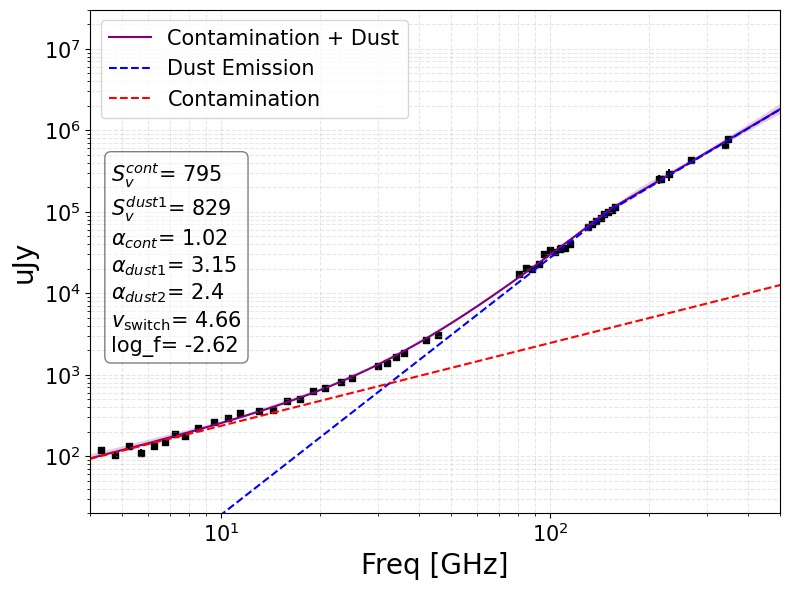

In [81]:
plot_tmcmc_results(3,33, sample3, np.mean(sample3[:,:], axis=0),mcmc_nu/33)